In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(43)

Dummy data

In [2]:
targets = [f'T{i:03d}' for i in range(10)]
models = [chr(0x03b1 + i) for i in range(8)]
df = pd.DataFrame(
    np.random.rand(len(targets) * len(models), 2).round(2), 
    columns=['true', 'pred'], 
    index=pd.MultiIndex.from_product([targets, models], names=['target', 'model'])
)
df = df.loc[np.random.choice(df.index, size=int(.6 * len(df.index)), replace=False)].sort_index()
df = df.groupby('target', group_keys=False).apply(lambda g: g.sort_values('pred', ascending=False))

In [3]:
def groupby_style(df):
    def highlight_max_column(series, color):
        css = np.where(series == series.max(), f'color: {color};', '')
        return pd.Series(css, index=series.index)
    
    def hline_bottom(group):
        style = np.full_like(group, fill_value=False)
        style[-1] = True
        style = np.where(style, 'border-bottom: 2px solid gray;', '')
        return pd.Series(style, index=group.index)
    
    color = df.groupby('target').transform(highlight_max_column, color='green')
    border = df.groupby('target').transform(hline_bottom)
    return color + border

df.style.apply(groupby_style, axis=None)

## Recall @ k

$$
\text{Recall @ k} = \frac{\text{# Relevant Items among the top-k}}{\text{# Relevant Items}}
$$

- Let's consider the true best decoy as the only relevant item, all other decoys are irrelevant. 
- So, for every query, recall is either 0% or 100%, depending whether the true best decoy is ranked in the top-k or not.
- For $k = 1 \dots 5$ we want to count how many queries place the true best decoy within the top-k.

In [4]:
t = df.loc['T002'].sort_values('pred', ascending=False).reset_index()
t['rank'] = np.arange(1, len(t) + 1)
print('True best is ranked #', t['true'].values.argmax() + 1)
t.set_index('rank').style.highlight_max(subset='true', color='""; color:green;')

True best is ranked # 3


,model,true,pred
rank,,,
1,α,0.48,0.64
2,γ,0.91,0.53
3,ε,0.95,0.41
4,η,0.63,0.28
5,θ,0.9,0.21
6,δ,0.1,0.18


For every, query, the index at which the true best is placed according to the predicted ranking. Index is 1-based.

In [5]:
idx_true_best = df.groupby('target', group_keys=False).apply(lambda g: g.sort_values('pred', ascending=False)['true'].values.argmax()) + 1
idx_true_best.to_frame('Rank of true best')

,Rank of true best
target,
T000,2
T001,2
T002,3
T003,5
T004,1
T005,5
T006,3
T007,1
T008,2


,Recall@k
k,
1,0.2
2,0.5
3,0.7
4,0.7
5,1.0
6,1.0
7,1.0


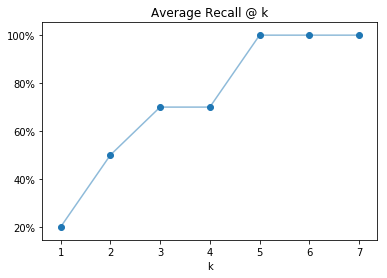

In [6]:
recall_at_k = (
    idx_true_best
    .value_counts()
    .sort_index()
    .reindex(np.arange(1, 8), fill_value=0)
    .cumsum()
    .rename('Recall@k')
    .rename_axis(index='k')
) / len(idx_true_best)

fig, ax = plt.subplots()
ax.plot(recall_at_k.index, recall_at_k.values, alpha=.5)
ax.scatter(recall_at_k.index, recall_at_k.values)
ax.set_title('Average Recall @ k')
ax.set_xlabel('k')
ax.set_xticks(recall_at_k.index)
ax.set_yticklabels([f'{t:.0%}' for t in ax.get_yticks()])

recall_at_k.to_frame()

## Normalized Discounted Cumulative Gain
[Wikipedia](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)
$$DCG_k = \sum_{i=1}^k \frac {2^{rel_i} - 1} {log_2 (i+1)}$$

In [7]:
def discounted_cumulative_gain(values):
    values = np.asarray(values)
    i = np.arange(1, len(values) + 1)
    dcg = np.cumsum((2 ** values - 1) / np.log2(i + 1))
    return dcg

def normalized_dcg(preds, true):
    preds = np.asarray(preds)
    true = np.asarray(true)
    ranking_preds = np.argsort(preds)[::-1]
    ranking_true = np.argsort(true)[::-1]
    dcg = discounted_cumulative_gain(true[ranking_preds])
    ideal_dcg = discounted_cumulative_gain(true[ranking_true])
    return dcg / ideal_dcg

In [8]:
t = df.loc['T002'].sort_values('pred', ascending=False).reset_index()
t['rank'] = np.arange(1, len(t) + 1)
t['DCG'] = discounted_cumulative_gain(t['true'])
t['nDCG'] = normalized_dcg(t['pred'], t['true'])
t.set_index('rank').style.highlight_max(subset='true', color='""; color:green;')

,model,true,pred,DCG,nDCG
rank,,,,,
1,α,0.48,0.64,0.394744,0.423603
2,γ,0.91,0.53,0.94936,0.638659
3,ε,0.95,0.41,1.4153,0.737317
4,η,0.63,0.28,1.65112,0.766058
5,θ,0.9,0.21,1.98616,0.860535
6,δ,0.1,0.18,2.01173,0.862063


target,T000,T001,T002,T003,T004,T005,T006,T007,T008,T009
k,,,,,,,,,,
1,0.04,0.16,0.42,0.80,1.00,0.83,0.24,1.00,0.09,0.76
2,0.55,0.56,0.64,0.79,0.84,0.89,0.47,0.90,0.47,0.75
3,0.58,0.54,0.74,0.86,0.79,0.71,0.76,0.98,0.51,0.69
4,0.68,0.72,0.77,0.87,0.95,0.73,0.76,,0.61,0.70
5,,,0.86,0.94,,0.91,0.76,,0.68,0.87
6,,,0.86,0.94,,,,,0.76,


,nDCG@k
k,
1,0.532762
2,0.687188
3,0.715406
4,0.754128
5,0.837090
6,0.854383


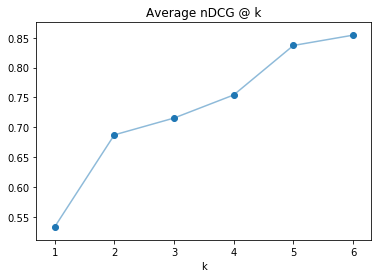

In [9]:
def max_k_normalized_dcg(group, max_k):
    dcg = discounted_cumulative_gain(group.nlargest(max_k, 'pred')['true'].values)
    ideal_dcg = discounted_cumulative_gain(group.nlargest(max_k, 'true')['true'].values)
    ndcg = dcg / ideal_dcg
    return pd.Series(ndcg, index=pd.RangeIndex(1, len(ndcg) + 1, name='k'))

all_ndcg = df.groupby('target').apply(lambda group: max_k_normalized_dcg(group, max_k=8)).unstack('target')
display(all_ndcg.style.format(lambda v: f'{v:.2f}' if np.isfinite(v) else ''))

ave_ndcg = all_ndcg.mean(axis='columns', skipna=True)
display(ave_ndcg.to_frame('nDCG@k'))

fig, ax = plt.subplots()
ax.plot(ave_ndcg.index, ave_ndcg.values, alpha=.5)
ax.scatter(ave_ndcg.index, ave_ndcg.values)
ax.set_title('Average nDCG @ k')
ax.set_xlabel('k')
ax.set_xticks(ave_ndcg.index);